# Tarea 1: Vocoder LPC
### Segunda entrega
Curso: EL7022 – Procesamiento de Voz en Telecomunicaciones

Profesor: Néstor Becerra

Profesor Auxiliar: Nicolas Grageda

Ayudantes: Catalina Murua y Jorge Wuth

Alumna: Isabel Marx

## Imports

In [ ]:
from google.colab import drive
from google.colab import files
from IPython.display import clear_output
from IPython.display import Audio
from IPython.display import display
import soundfile
import matplotlib.pyplot as plt
import numpy as np
import math

## Carga de archivos

In [ ]:
drive.mount('/content/drive')
path1 = '/content/drive/My Drive/T11.wav'
path2 = '/content/drive/My Drive/T12.wav'
path3 = '/content/drive/My Drive/T1SSSS.wav'
clear_output(wait=True)

Mounted at /content/drive


In [ ]:
initial_audio1 = Audio(path1, rate=8000)
display(initial_audio1)

In [ ]:
initial_audio2 = Audio(path2, rate=8000)
display(initial_audio2)

In [ ]:
initial_audio2 = Audio(path3, rate=8000)
display(initial_audio2)

## Primera entrega

Definición de parámetros

In [ ]:
w_L = 216 # window length
n_coef1 = 12 # number of LPC coefficients
n_R1 = n_coef1 + 1 # number of elements of R(1 + coefficients)
T0 = 36 # samples of a period

In [ ]:
s_L2 = 78192 # signal length in samples
n_w2 = 362 # number of windows
w_L = 216 # window length
n_coef2 = 12 # number of LPC coefficients
n_R2 = n_coef2 + 1 # number of elements of R(1 + coefficients)

In [ ]:
def signal(path):
  signal, sampling_rate = soundfile.read(path)
  if path == path1:
    length = 24192
  elif path == path2:
    length = 78192
  else:
    length = len(signal)
  audio_signal = signal[0:length]
  s = np.zeros(length)
  if len(audio_signal.shape) == 2:
    for i in range(length):
      s[i] = audio_signal[i][0]
  else:
    s = audio_signal
  return(s)

In [ ]:
s1 = signal(path1)

In [ ]:
def windows(s):
  L = len(s)
  r = L%216
  t = int((L-r)/216)
  w = []
  w_L = 216
  if r != 0:
    t += 1
  for i in range(t):
    if i == t:
      w.append([])
      w[i] = s[w_L*i:]
    else:
      w.append([])
      w[i] = s[w_L*i:w_L*(i+1)]
  return(w)

In [ ]:
w1 = windows(s1)

Text(0, 0.5, 'Amplitud')

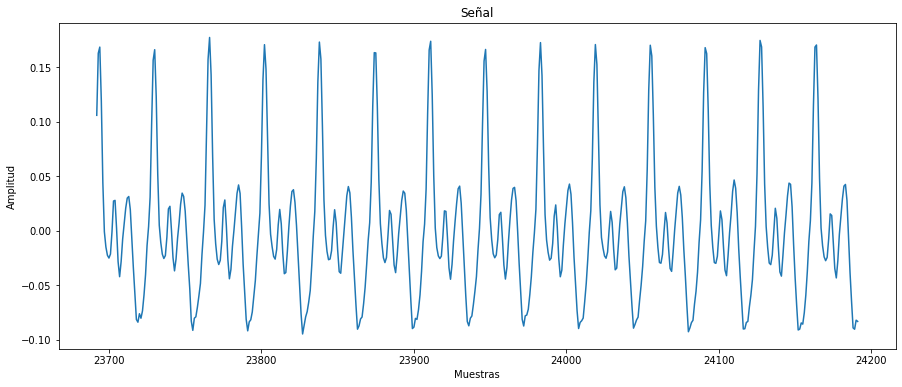

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(s1)-500,len(s1)), s1[len(s1)-500:len(s1)])
plt.title('Señal')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

Se plotean las 3 últimas ventanas.

Text(0, 0.5, 'Amplitud')

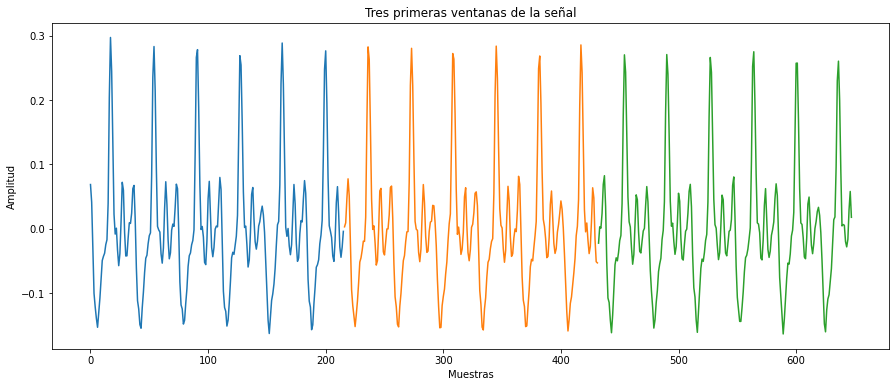

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(3):
  plt.plot(range(216*i,216*(i+1)),w1[i])
plt.title('Tres primeras ventanas de la señal')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

In [ ]:
def plot(w):
  plt.figure(figsize=(15, 6))
  for i in range(len(w)-4,len(w)):
    L_wi = len(w[i])
    plt.plot(range(216*i,216*i+L_wi),w[i])
  plt.title('Tres últimas ventanas de la señal')
  plt.xlabel('Muestras')
  plt.ylabel('Amplitud')

Se crean los vector de correlaciones R para cada ventana con 'número de coeficientes + 1' elementos.

In [ ]:
def correlation_R(n_R,w):
  n_w = len(w)
  R = []
  for i in range(n_w):
    R.append([])
    for k in range(1,n_R+1):
      suma = 0
      if i == n_w-1:
        w_L = len(w[-1])
      else:
        w_L = 216
      for m in range(1,w_L+1-(k-1)):
        r = w[i][m-1]*w[i][m+k-2]
        suma = suma + r
      R[i].append(suma)
  R = np.array(R)
  return(R)

In [ ]:
R1 = correlation_R(n_R1,w1)

Se crean matrices Toeplitz(Rmatrix) a partir de los 'n_coeficientes' primeros elementos de cada ventana de R.

In [ ]:
def toeplitz(n_w,n_coef,R):
  n_R = n_coef+1
  Rmatrix=[]
  for i in range(1,n_w+1):
    Rmatrix.append([])
    c1=[]
    for h in range(1,n_coef+1):
      c1.append(R[i-1][h-1])
    Rmatrix[i-1].append(c1)
    for e in range(2,n_R):
      cn = []
      for u in range(e-1):
        cn.append(c1[e-1-u])
      for j in range(e-1,n_coef):
        cn.append(c1[j-(e-1)])
      Rmatrix[i-1].append(cn)
  Rmatrix = np.array(Rmatrix)
  return(Rmatrix)

In [ ]:
RM1 = toeplitz(len(w1),n_coef1,R1)

Se calculan los coeficientes para cada ventana multiplicando la inversa de la matriz Toeplitz de cada ventana por los últimos 'n_coeficientes - 1' elementos del vector R de cada ventana.

In [ ]:
def LPC(n_w,R,Rmatrix):
  A=[];
  v1=0;
  for i in range(n_w):
    A.append([])
    a = -np.matmul(np.linalg.inv(Rmatrix[i]),np.array(R[i][1:]))
    a = np.insert(a, 0, 1)
    A[i] = a
  return(A)

In [ ]:
A1 = LPC(len(w1),R1,RM1)

In [ ]:
def energy(n_w,n_coef,A,R):
  # Cálculo de energía
  E = []
  for i in range(1,n_w+1):
    E.append([])
    suma = 0
    for k in range(1,n_coef+1):
      suma = suma + A[i-1][k-1]*R[i-1][k-1]
    E[i-1] = R[i-1][0] - suma
  E = np.array(E)
  Emax = np.max(E)
  E = np.divide(E,Emax)
  return(E)

In [ ]:
E1 = energy(len(w1),n_coef1,A1,R1)

In [ ]:
def gain(E):
  # Cálculo de ganancia
  G = np.sqrt(E)
  return(G)

In [ ]:
G1 = gain(E1)

Se genera un tren de impulsos con las ganancias de las ventanas espaciadas a T_0 = 37 muestras.

In [ ]:
def train(s_L,G):
  # Tren de impulsos
  trenG0 = np.zeros([s_L])
  trenG0[0] = G[0]
  for i in range(1,s_L):
    if i > ((s_L-(s_L%216))/216)*216:
      trenG0[math.ceil(i/T0)*T0-1] = G[-1]
    else:
      trenG0[math.ceil(i/T0)*T0-1] = G[math.floor((i-1)/w_L)]
  return(trenG0)

In [ ]:
T1 = train(len(s1),G1)

Se plotean las 5 primeras ventanas del tren de impulsos:

Text(0, 0.5, 'Amplitud')

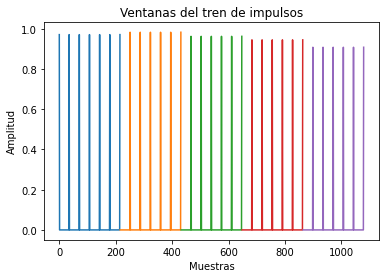

In [ ]:
for i in range(5):
  plt.plot(range(216*i,216*(i+1)),T1[216*i:216*(i+1)])
plt.title('Ventanas del tren de impulsos')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')

Cálculos de Filtro LPC.

In [ ]:
def LPC_filter(s_L,n_coef,A,trenG0):
  # Filtro LPC

  # vector de s_L ceros:
  y = np.zeros([s_L])

  # para cada elemento:
  for n in range(s_L):

    # se iguala la muestra al correspondiente en el tren de impulsos
    y[n] = trenG0[n]

    # cuando n = 0, sólo se iguala 'y' con el tren y sigue a la siguiente 
    # iteración. Si n es mayor que 1:
    if n > 0:

      # se inicia k en 1
      k = 1

      # mientras la resta de n y k no sea negativa, y k no supere el número de 
      # coeficientes:
      while n+1-k > 0 and k < n_coef+1:

        # se toma y[n] y se suma el coeficiente k(que parte en 1 y llega a n_coef)
        # multiplicado por el 'y' en n-k:
        y[n] = y[n] - A[math.ceil((n+1)/216)-1][k]*y[n-k]

        # k se incrementa en 1 con cada iteración, hasta llegar a n_coef, cuando
        # se terminan de sumar los retardos y se pasa al siguiente loop.
        k += 1
  return(y)

In [ ]:
y1 = LPC_filter(len(s1),n_coef1,A1,T1)

In [ ]:
display(initial_audio1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'C' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'o' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'd' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: Legend does not support 'i' instances.
A proxy artist may be used instead.
See: http:/

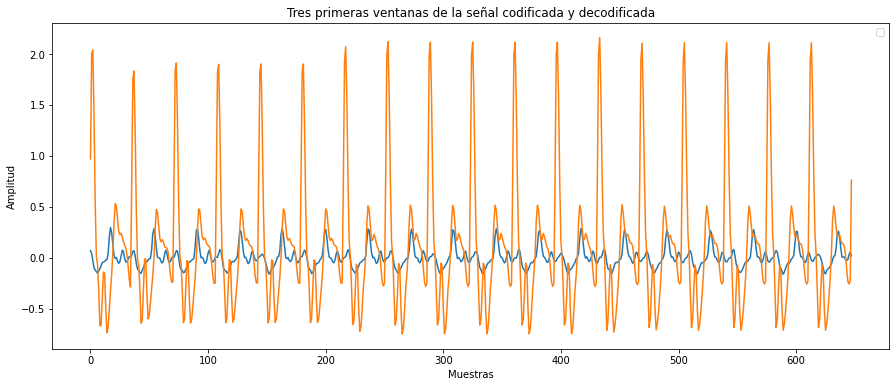

In [ ]:
#36
plt.figure(figsize=(15, 6))
plt.plot(range(0,216*3),s1[0:216*3])
plt.plot(range(0,216*3),y1[0:216*3])
plt.title('Tres primeras ventanas de la señal codificada y decodificada')
plt.legend('Codificada','Decodificada')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
final_audio36 = Audio(y1, rate=8000)
display(final_audio36)

# Segunda entrega

In [ ]:
s_L2 = 78192 # signal length in samples
n_w2 = 362 # number of windows
w_L = 216 # window length
n_coef2 = 12 # number of LPC coefficients
n_R2 = n_coef2 + 1 # number of elements of R(1 + coefficients)

### Generación de ventanas

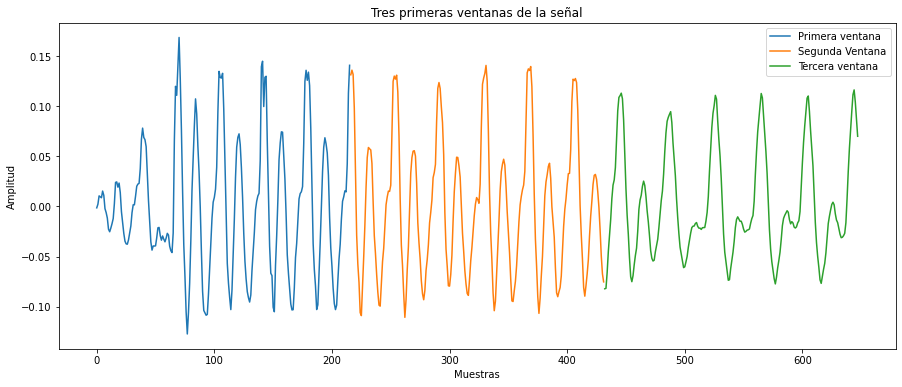

In [ ]:
s2 = signal(path2)
w2 = windows(s2)
plt.figure(figsize=(15, 6))
for i in range(3):
  plt.plot(range(216*i,216*(i+1)),w2[i])
plt.title('Tres primeras ventanas de la señal')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.legend(['Primera ventana','Segunda Ventana','Tercera ventana'])

In [ ]:
R2 = correlation_R(n_R2,w2)
RM2 = toeplitz(n_w2,n_coef2,R2)
A2 = LPC(n_w2,R2,RM2)
E2 = energy(n_w2,n_coef2,A2,R2)
G2 = gain(E2)

### Vector de correlaciones completo para cada ventana

In [ ]:
def correlation_wL(n_R,n_w,w):
  RwL = []
  for i in range(n_w):
    RwL.append([])
    for k in range(1,len(w[i])+1):
      suma = 0
      for m in range(1,len(w[i])+1-(k-1)):
        r = w[i][m-1]*w[i][m+k-2]
        suma = suma + r
      RwL[i].append(suma)
  return(RwL)

In [ ]:
RwL2 = correlation_wL(n_R2,n_w2,w2)

In [ ]:
def window_period(n_w,threshold,RwL,limit):
  T0s = []
  R_tau = []
  for i in range(n_w):
    RwL[i] = (RwL[i])/(RwL[i][0])
    j = limit
    top = 60
    while j != 1:
      if j == top-1:
        T0s.append(0)
        R_tau.append(0)
        j = 0
      elif RwL[i][j] >= 1 - threshold and RwL[i][j] >= RwL[i][j+1]:
        T0s.append(j)
        R_tau.append(RwL[i][j])
        j = 0
      j += 1

  plt.figure(figsize=(15, 6))
  j = 3
  maxplot = 45
  for i in range(10*j,10*(j+1)):
    p1 = plt.plot(range(maxplot),RwL[i][0:maxplot]/RwL[i][0])
    c = p1[0].get_color()
    if T0s[i] == 0:
      plt.plot(maxplot-1,RwL[i][maxplot-1],'*',markersize=10, color=c, label=str(i+1))
    else:
      plt.plot(T0s[i],R_tau[i],'*',markersize=10, color=c, label=str(i+1))
  plt.plot(range(maxplot),[1-threshold]*maxplot,':',color='k')
  line = [j-1 for j in [i/((maxplot-1)/2) for i in list(range(maxplot))]]
  plt.plot([limit]*maxplot,line,':',color='k')
  plt.legend()
  plt.title('Vectores de correlación para cada ventana')
  plt.xlabel('Muestras')
  plt.ylabel('R(s)')
  return(T0s,R_tau)

### Determinación de ventanas sonoras y sordas según un umbral, normalizando el vector de correlaciones por R(0).

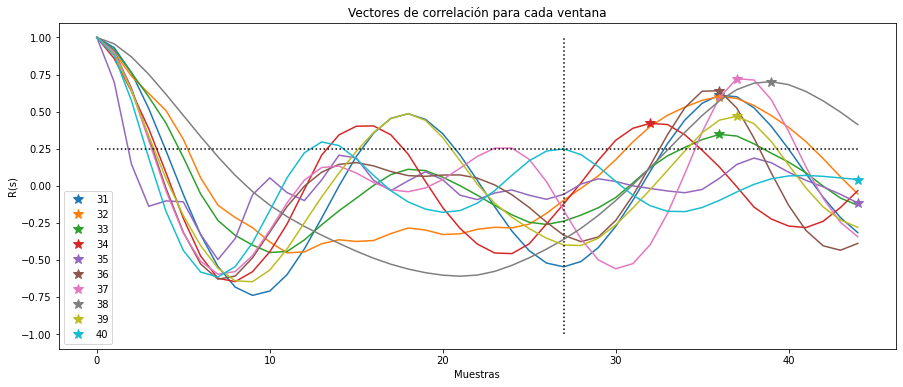

In [ ]:
umbral = 0.3342
umbral = 0.75
[T0s2, R_tau2] = window_period(n_w2,umbral,RwL2,27)

In [ ]:
def F0(T0):
  F0 = []
  for t0 in T0:
    if t0 == 0:           # sordo
      F0.append(0)
    else:
      F0.append(1/t0)    # sonoro
  return(F0)

In [ ]:
def F0Double(T0):
  F0 = []
  for t0 in T0:
    if t0 == 0:           # sordo
      F0.append(0)
    else:
      F0.append(1/(t0*2))    # sonoro
  return(F0)

In [ ]:
def F0Half(T0):
  F0 = []
  for t0 in T0:
    if t0 == 0:           # sordo
      F0.append(0)
    else:
      F0.append(1/(t0/2))    # sonoro
  return(F0)

In [ ]:
def display_F0(F0):
  for j in range(2):
    plt.figure(figsize=(15, 6))
    plt.plot(range(180*j,180*j+180),F0[180*j:180*j+180])
    str1 = str(j+1) + 'a mitad de F0'
    plt.title(str1)
    plt.xlabel('Muestras')
    plt.ylabel('F0')

### Se grafica F0:

In [ ]:
def T0Half(T0):
  T0n = []
  for t0 in T0:
    T0n.append(int(math.floor(t0/2)))    # sonoro
  return(T0n)

In [ ]:
def T0Double(T0):
  T0n = []
  for t0 in T0:
    T0n.append(t0*2)    # sonoro
  return(T0n)

In [ ]:
F0s2 = F0(T0s2)

In [ ]:
def linear(p1x,p1y,p2x,p2y):
  mx = max(p1x,p2x)
  mn = min(p1x,p2x)
  xs = []
  while(mn < mx + 1):
    xs.append(mn)
    mn += 1
  m = (p2y-p1y)/(p2x-p1x)
  j = mx
  ys = []
  for i in xs:
    ys.append(m*(i-p1x) + p1y)
  xs.pop()
  xs.pop(0)
  ys.pop()
  ys.pop(0)
  return(xs,ys)

In [ ]:
def smoothT0(T0,samples_between,samples_max,peak_dif):
  F0sFF = []
  F0s = []
  for t0 in T0:
    if t0 == 0:           # sordo
      F0s.append(0)
      F0sFF.append(0)
    else:
      F0s.append(1/t0)
      F0sFF.append(1/t0)  

  k = 0
  h = 1
  while k < len(F0s)-1 and k < k+h:
    if F0s[k] != 0:
      if F0s[k+1] == 0:
        g = 0
        h = 1
        while h < samples_between:
          if F0s[k+g+1] == 0:
            g += 1
            h += 1
          else:
            h = samples_between
        if F0s[k+g+1] != 0:
          f0sf = linear(k,F0s[k],k+g+1,F0s[k+g+1])
          for u,v in enumerate(f0sf[0]):
            F0sFF[k+u] = f0sf[1][u]
        k += g    

      elif abs(F0s[k+1] - F0s[k]) > peak_dif:
        g = 0
        h = 1
        while h < samples_max:
          if -abs(F0s[k+g+1] - F0s[k]) < peak_dif:
          #if F0s[k+g+1] > F0s[k] + peak_dif:
            g += 1
            h += 1
          else:
            h = samples_max
        if F0s[k+g+1] != 0:
          f0sf = linear(k,F0s[k],k+g+1,F0s[k+g+1])
          for u,v in enumerate(f0sf[0]):
            F0sFF[k+u] = f0sf[1][u]
        k += g

      else:
        k += 1
    else:
      k += 1
  for j in range(2):
    plt.figure(figsize=(15, 6))
    plt.plot(range(150*j,150*j+150),F0s[150*j:150*j+150])
    plt.plot(range(150*j,150*j+150),F0sFF[150*j:150*j+150],'m')
    str1 = str(j+1) + 'a mitad de la señal'
    plt.title(str1)
    plt.xlabel('samples')
    plt.ylabel('F0')
  plt.figure(figsize=(15, 6))
  plt.plot(range(len(F0s)),F0s)
  plt.plot(range(len(F0sFF)),F0sFF,'m')
  str2 = 'Señal completa'
  plt.title(str2)
  plt.xlabel('samples')
  plt.ylabel('F0')
  return(F0sFF)

In [ ]:
def smoothT0_20(F0s0,samples_between,samples_max,peak_dif):
  F0s0.append(0)
  F0s0.append(0)
  F0sFF = []
  F0s = []
  for f0 in F0s0:
    F0s.append(f0)
    F0sFF.append(f0)
  k = 0
  h = 1
  i = 0
  while i < len(F0s)-2:
    if F0s[i] != 0 and F0s[i+1] == 0 and F0s[i+2] != 0:
      F0sFF[i+1] = (F0s[i]+F0s[i+2])/2
    i += 1
  for j in range(2):
    plt.figure(figsize=(15, 6))
    plt.plot(range(150*j,150*j+150),F0s[150*j:150*j+150],'c')
    plt.plot(range(150*j,150*j+150),F0sFF[150*j:150*j+150],'m')
    str1 = str(j+1) + 'a mitad de la señal'
    plt.title(str1)
    plt.xlabel('samples')
    plt.ylabel('F0')
  return(F0sFF)

In [ ]:
"""
def smoothT0(T0s,samples_between,samples_max,peak_dif):
  ceros = 4
  F0s = []
  F0sFF = []
  for t0 in T0s:
    if t0 == 0:           # sordo
      F0s.append(0)
      F0sFF.append(0)
    else:
      F0s.append(1/t0)    # sonoro
      F0sFF.append(0) 
  i = 0
  h = 1
  while i < len(F0s):
    # Caídas a 0
    if F0s[i] != 0:
      g = 0
      h = 1
      while i+h < ceros:
        if F0s[i+h] == 0:
          g += 1
          h += 1
        else:
          break
      if g != 0 and F0sFF[i+h] != 0:
        F0sFF[i+1:i+h-1] = linear(i,F0s[i],i+h,F0s[i+h])
  return(F0s,F0sFF)

"""

'\ndef smoothT0(T0s,samples_between,samples_max,peak_dif):\n  ceros = 4\n  F0s = []\n  F0sFF = []\n  for t0 in T0s:\n    if t0 == 0:           # sordo\n      F0s.append(0)\n      F0sFF.append(0)\n    else:\n      F0s.append(1/t0)    # sonoro\n      F0sFF.append(0) \n  i = 0\n  h = 1\n  while i < len(F0s):\n    # Caídas a 0\n    if F0s[i] != 0:\n      g = 0\n      h = 1\n      while i+h < ceros:\n        if F0s[i+h] == 0:\n          g += 1\n          h += 1\n        else:\n          break\n      if g != 0 and F0sFF[i+h] != 0:\n        F0sFF[i+1:i+h-1] = linear(i,F0s[i],i+h,F0s[i+h])\n  return(F0s,F0sFF)\n\n'

In [ ]:
F0s2 = F0(T0s2)

### Se suavizan las curvas:

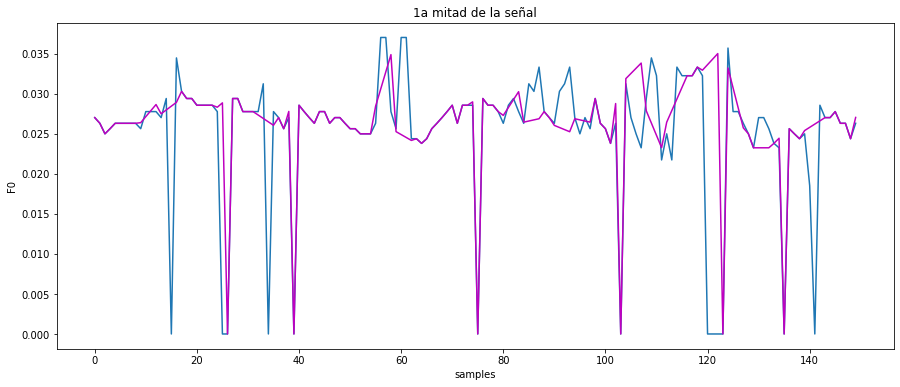

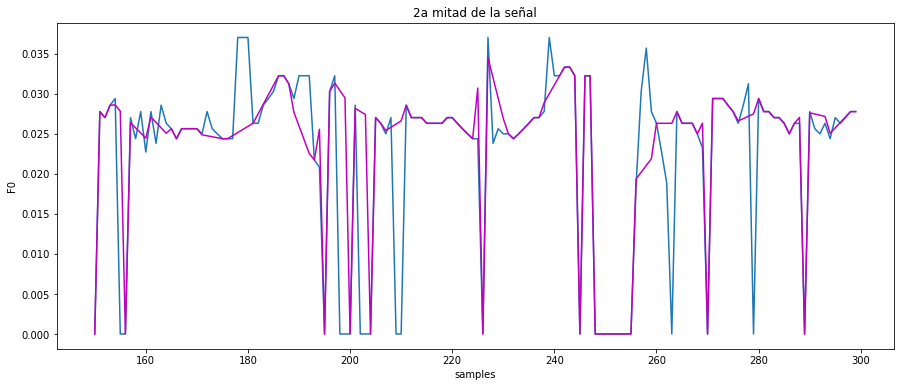

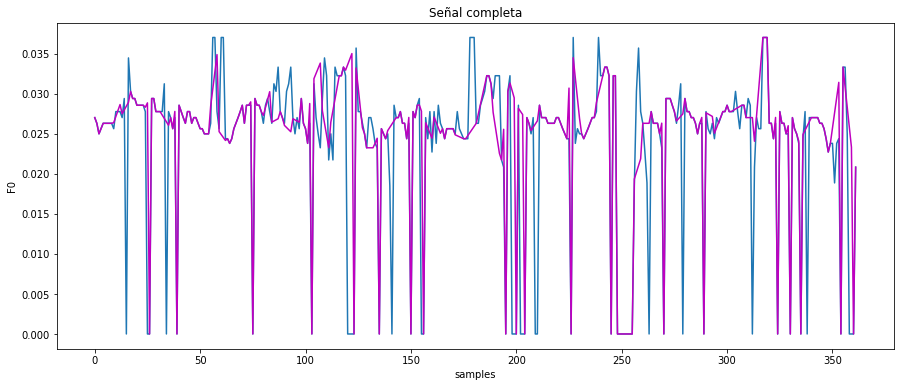

In [ ]:
F0sf2 = smoothT0(T0s2,5,5,0.0020)

In [ ]:
def F02T0(F0sFF):
  T0sFF = []
  for f0 in F0sFF:
    if f0 == 0:           # sordo
      T0sFF.append(0)
    else:
      T0sFF.append(1/f0)    # sonoro
  T0sFF = [round(i) for i in T0sFF]
  return(T0sFF)

In [ ]:
T0sf2 = F02T0(F0sf2)

### Se genera T0 con los nuevos F0 obtenidos

In [ ]:
def trainT0s(s_L,n_w,E,G,T0s):
  # Tren de impulsos
  trenG0 = np.zeros([s_L2])
  mean = 0
  for i in range(n_w):
    std = E[i]/2
    if i == 0:
      if T0s[0] == 0:
        samples_noise = w_L
        noise = np.random.normal(mean, std, size=samples_noise)
        trenG0[0:w_L] = noise
        t_rem1 = 0
        t_rem2 = 0
      else:
        h = 0
        while h < w_L:
          trenG0[h] = G2[0]
          h += T0s[0]
        h -= T0s[0]
        t_rem1 = w_L - h
        t_rem2 = T0s[0] - t_rem1
    
    else:
      if T0s[i] == 0:
        j = i
        h = 1
        while h != 0 and j > 0:
          t0 = T0s[j-1]
          if t0 == 0:
            j -= 1
          else:
            h = 0
        samples_noise = w_L*(i-j) + t_rem1 + w_L -2
        noise = np.random.normal(mean, std, size=samples_noise)
        trenG0[w_L*j-t_rem1+2:w_L*(i+1)] = noise
        t_rem1 = 0
        t_rem2 = 0
      else:
        h = t_rem2
        while h < w_L:
          trenG0[w_L*i+h] = G[i]
          h += T0s[i]
        h -= T0s[i]
        t_rem1 = w_L - h
        t_rem2 = T0s[i] - t_rem1
  return(trenG0)

### Sin suavizar:

In [ ]:
T2 = trainT0s(s_L2,n_w2,E2,G2,T0s2)

Text(0.5, 0, 'Muestras')

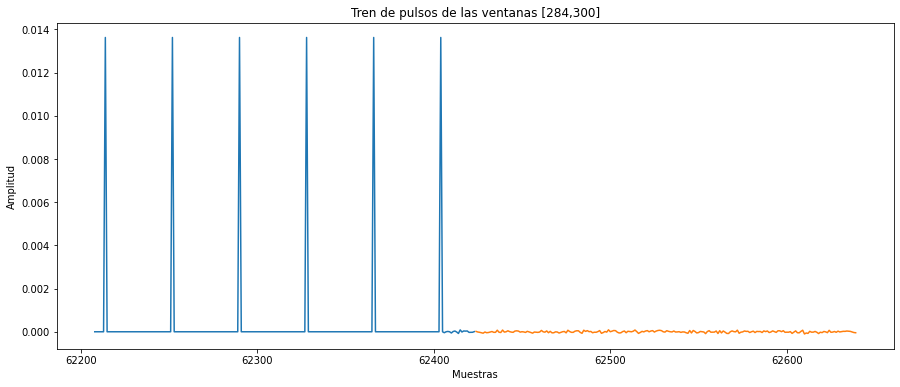

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(288,290):
  plt.plot(range(216*i,216*(i+1)),T2[216*i:216*(i+1)])
plt.title('Tren de pulsos de las ventanas [284,300]')
plt.ylabel('Amplitud')
plt.xlabel('Muestras')

Text(0.5, 0, 'Muestras')

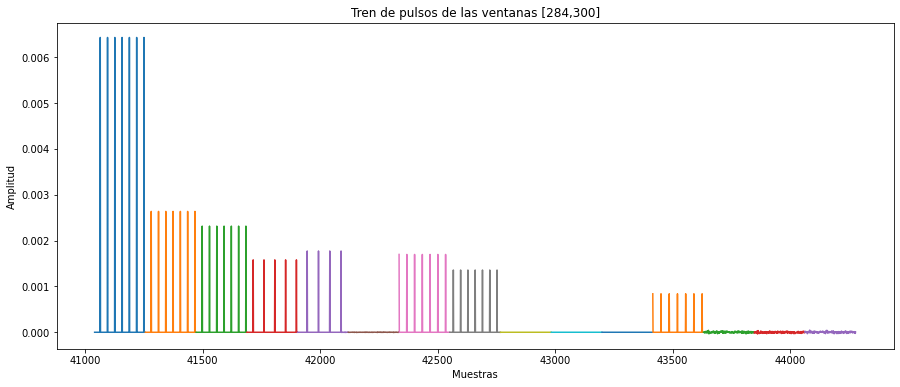

In [ ]:
plt.figure(figsize=(15, 6))
for i in range(190,205):
  plt.plot(range(216*i,216*(i+1)),T2[216*i:216*(i+1)])
plt.title('Tren de pulsos de las ventanas [284,300]')
plt.ylabel('Amplitud')
plt.xlabel('Muestras')

In [ ]:
y2 = LPC_filter(s_L2,n_coef2,A2,T2)
"""
plt.figure(figsize=(15, 6))
f_w = 362
plt.plot(range(0,216*f_w),s2[0:216*f_w])
plt.plot(range(0,216*f_w),y2[0:216*f_w])
plt.title('Señal decodificada')
plt.ylabel('Amplitud')
plt.xlabel('Muestras')
final_audio2 = Audio(y2, rate=8000)
display(final_audio2)
"""

"\nplt.figure(figsize=(15, 6))\nf_w = 362\nplt.plot(range(0,216*f_w),s2[0:216*f_w])\nplt.plot(range(0,216*f_w),y2[0:216*f_w])\nplt.title('Señal decodificada')\nplt.ylabel('Amplitud')\nplt.xlabel('Muestras')\nfinal_audio2 = Audio(y2, rate=8000)\ndisplay(final_audio2)\n"

### Con suavizar:

In [ ]:
Tf2 = trainT0s(s_L2,n_w2,E2,G2,T0sf2)

In [ ]:
display(initial_audio2)

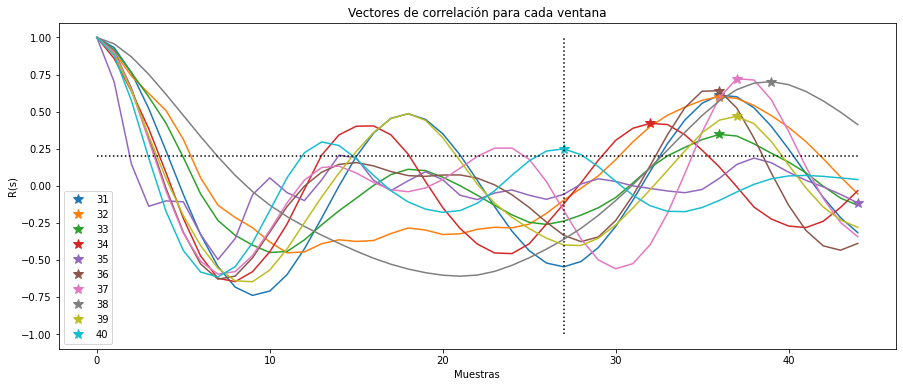

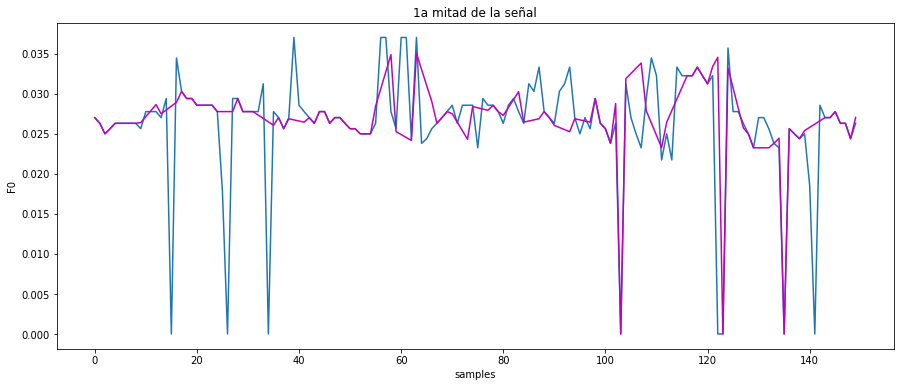

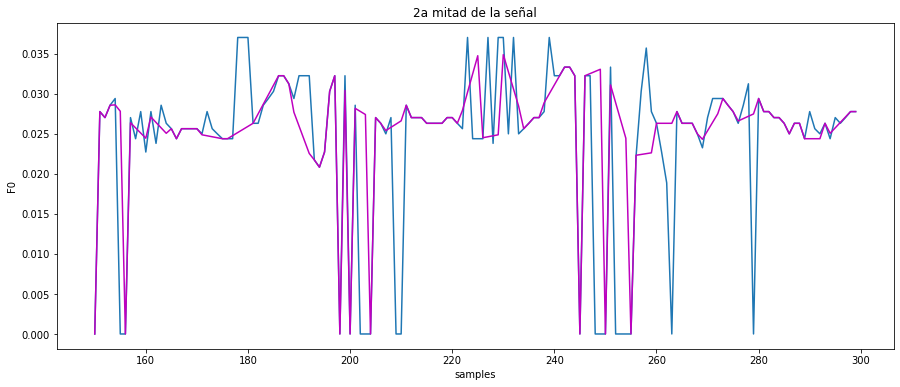

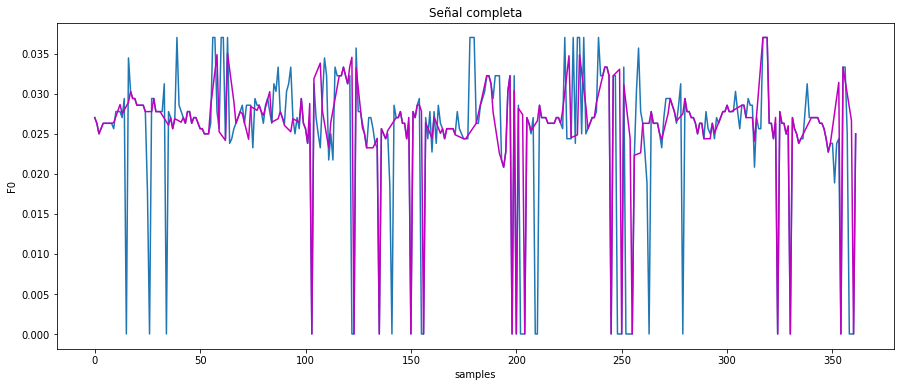

In [ ]:
umbral = 0.3342
umbral = 0.8
[T0s2, R_tau2] = window_period(n_w2,umbral,RwL2,27)
F0sf2 = smoothT0(T0s2,5,5,0.0020)
T0sf2 = F02T0(F0sf2)
Tf2 = trainT0s(s_L2,n_w2,E2,G2,T0sf2)
yf2 = LPC_filter(s_L2,n_coef2,A2,Tf2)
final_audiof2 = Audio(yf2, rate=8000)
display(final_audiof2)

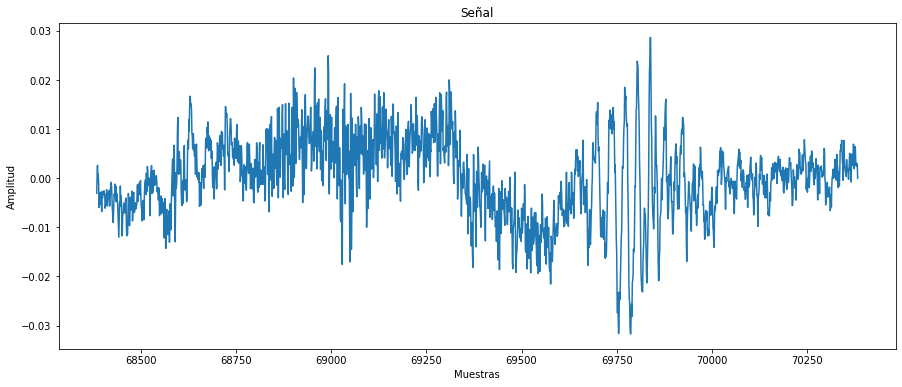

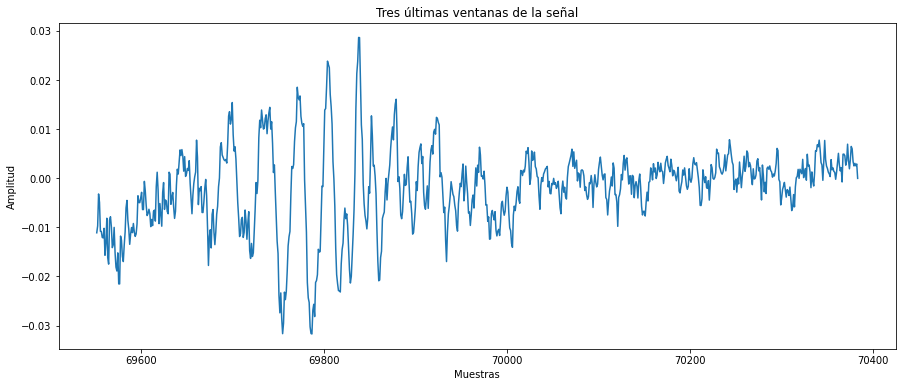

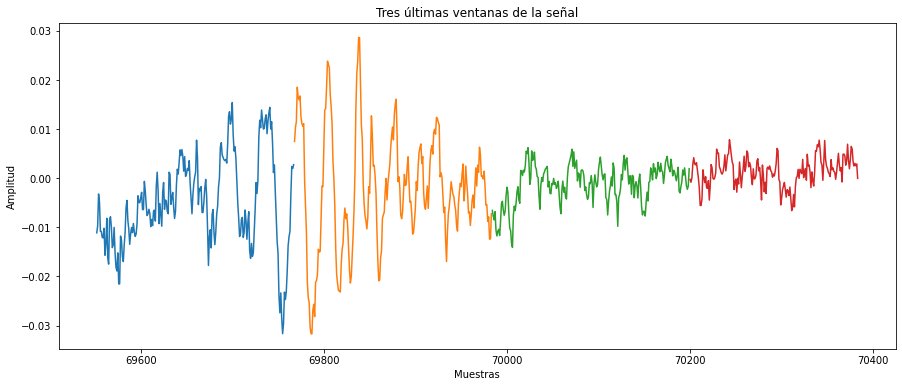

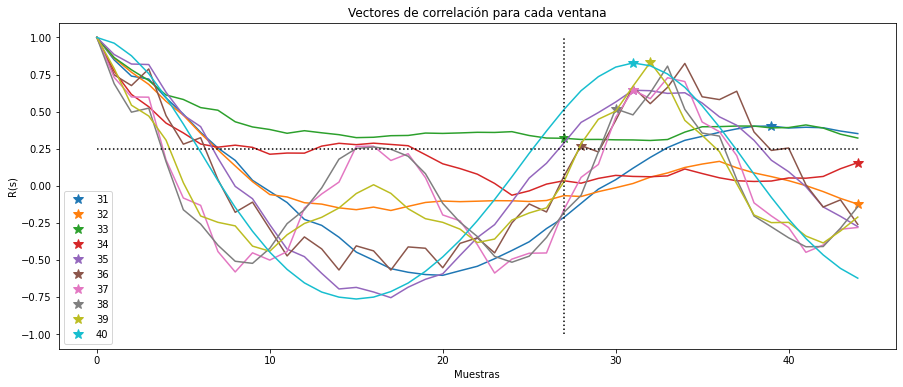

In [ ]:
s3 = signal(path3)
w3 = windows(s3)
plt.figure(figsize=(15, 6))
plt.plot(range(len(s3)-2000,len(s3)), s3[len(s3)-2000:len(s3)])
plt.title('Señal')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plt.figure(figsize=(15, 6))
plt.plot(range(216*(len(w3)-4),216*(len(w3)-1)+len(w3[-1])),s3[216*(len(w3)-4):])
plt.title('Tres últimas ventanas de la señal')
plt.xlabel('Muestras')
plt.ylabel('Amplitud')
plot(w3)
R3 = correlation_R(n_R1,w3)
RM3 = toeplitz(len(w3),n_coef1,R3)
A3 = LPC(len(w3),R3,RM3)
E3 = energy(len(w3),n_coef1,A3,R3)
G3 = gain(E3)
RwL3 = correlation_wL(n_R2,len(w3),w3)
umbral = 0.3342
umbral = 0.75
[T0s3, R_tau3] = window_period(len(w3),umbral,RwL3,27)
T3 = trainT0s(len(s3),len(w3),E3,G3,T0s3)

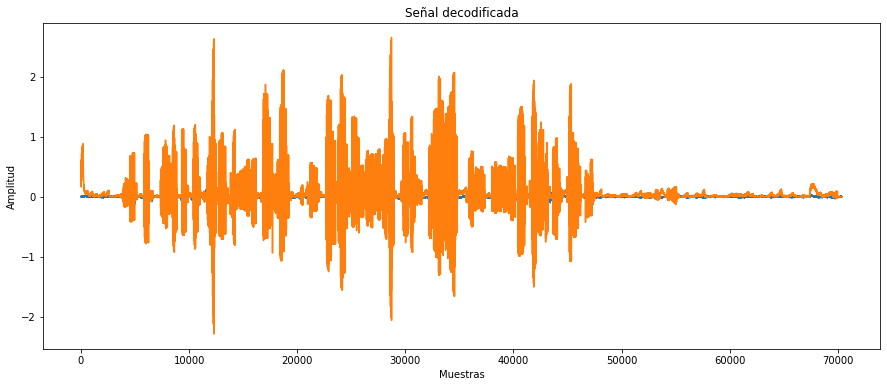

In [ ]:
y3 = LPC_filter(len(s3),n_coef1,A3,T3)
plt.figure(figsize=(15, 6))
f_w = len(w3)
plt.plot(range(0,len(s3)),s3[0:len(s3)])
plt.plot(range(0,len(s3)),y3[0:len(s3)])
plt.title('Señal decodificada')
plt.ylabel('Amplitud')
plt.xlabel('Muestras')
final_audio3 = Audio(y3, rate=8000)
display(final_audio3)

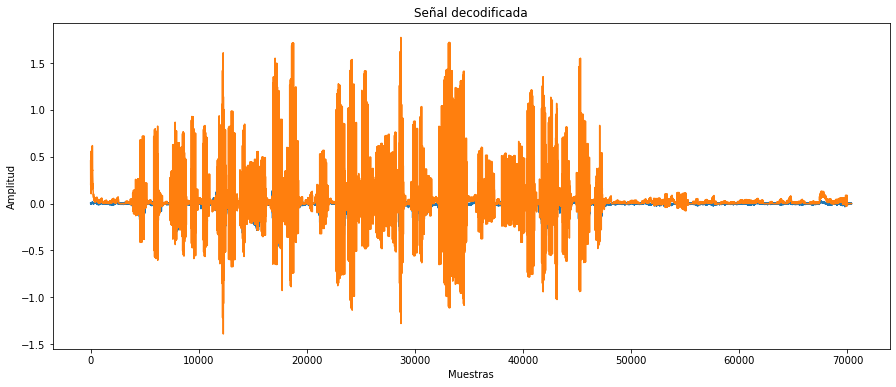

In [ ]:
T0s3_double = T0Double(T0s3)
T3 = trainT0s(len(s3),len(w3),E3,G3,T0s3_double)
y3 = LPC_filter(len(s3),n_coef1,A3,T3)
plt.figure(figsize=(15, 6))
f_w = len(w3)
plt.plot(range(0,len(s3)),s3[0:len(s3)])
plt.plot(range(0,len(s3)),y3[0:len(s3)])
plt.title('Señal decodificada')
plt.ylabel('Amplitud')
plt.xlabel('Muestras')
final_audio3 = Audio(y3, rate=8000)
display(final_audio3)

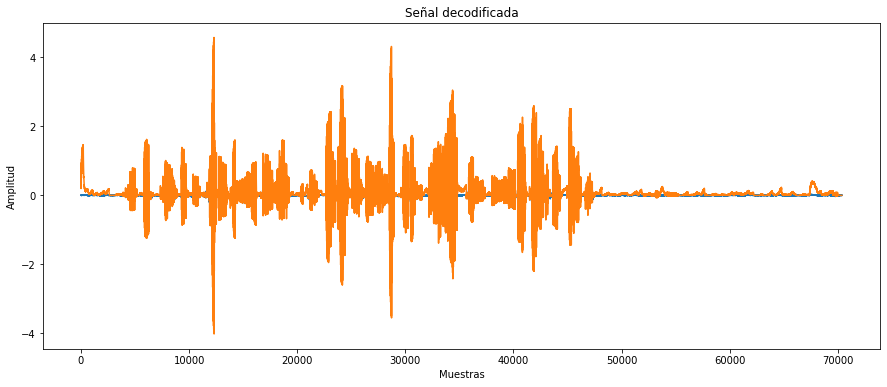

In [ ]:
T0s3_half = T0Half(T0s3)
T3 = trainT0s(len(s3),len(w3),E3,G3,T0s3_half)
y3 = LPC_filter(len(s3),n_coef1,A3,T3)
plt.figure(figsize=(15, 6))
f_w = len(w3)
plt.plot(range(0,len(s3)),s3[0:len(s3)])
plt.plot(range(0,len(s3)),y3[0:len(s3)])
plt.title('Señal decodificada')
plt.ylabel('Amplitud')
plt.xlabel('Muestras')
final_audio3 = Audio(y3, rate=8000)
display(final_audio3)